# LSTM Poker Agent V3 - Better Architecture + Large Training Loop

This notebook combines:
- **Better DRQN Architecture** from V2: LSTM processes full state sequences (not just action tokens)
- **Large Training Loop** from Fixed version: Session-based training with proper LSTM state management

## Key Features:
1. **LSTM processes full state sequence** - proper DRQN architecture
2. **Session-based training** - 100 sessions x 100 hands = 10,000 total hands
3. **LSTM hidden state persists across hands in a session** - captures opponent patterns
4. **Epsilon decay per hand** (not per session) - faster exploration decay
5. **Batched training** with proper episode handling
6. **Initial hidden state stored in replay buffer** - for accurate training

In [1]:
# Cell 1: Dependencies & Setup
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from collections import deque
import random
import matplotlib.pyplot as plt
from typing import Optional, Tuple, List, Dict, Any

from pokerkit import Automation, NoLimitTexasHoldem, Card

# Constants
SEED = 42

# Set random seeds
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Cell 2: Action Space

# Environment action space
ENV_FOLD = 0
ENV_CHECK_CALL = 1
ENV_BET_RAISE = 2
NUM_ACTIONS = 3

In [3]:
# Cell 3: Custom Gym Wrapper for PokerKit

class PokerKitGymEnv(gym.Env):
    """Gymnasium wrapper for PokerKit's No-Limit Texas Hold'em."""
    
    def __init__(self, num_players: int = 2, starting_stack: int = 1000, 
                 small_blind: int = 5, big_blind: int = 10):
        super().__init__()
        
        self.num_players = num_players
        self.starting_stack = starting_stack
        self.small_blind = small_blind
        self.big_blind = big_blind
        
        # State: 2 hole cards (52*2) + 5 board (52*5) + stacks + pot + position + street
        self.game_state_dim = 52*2 + 52*5 + num_players + 1 + 1 + 4  # 372
        
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(self.game_state_dim,), dtype=np.float32
        )
        self.action_space = spaces.Discrete(NUM_ACTIONS)
        
        self.state = None
        self.agent_player_index = 0
        
    def _card_to_index(self, card: Card) -> int:
        ranks = '23456789TJQKA'
        suits = 'cdhs'
        rank_idx = ranks.index(card.rank)
        suit_idx = suits.index(card.suit)
        return rank_idx * 4 + suit_idx
    
    def _encode_card(self, card: Optional[Card]) -> np.ndarray:
        encoding = np.zeros(52, dtype=np.float32)
        if card is not None:
            encoding[self._card_to_index(card)] = 1.0
        return encoding
    
    def _flatten_cards(self, cards) -> List:
        flat = []
        for item in cards:
            if hasattr(item, 'rank'):
                flat.append(item)
            else:
                flat.extend(self._flatten_cards(item))
        return flat
    
    def _get_game_state(self) -> np.ndarray:
        """Get the full game state as a flat vector."""
        state_vector = []
        
        # Hole cards (104 dims)
        hole_cards = self._flatten_cards(self.state.hole_cards[self.agent_player_index])
        for i in range(2):
            if i < len(hole_cards):
                state_vector.extend(self._encode_card(hole_cards[i]))
            else:
                state_vector.extend(np.zeros(52, dtype=np.float32))
        
        # Board cards (260 dims)
        board_cards = self._flatten_cards(self.state.board_cards)
        for i in range(5):
            if i < len(board_cards):
                state_vector.extend(self._encode_card(board_cards[i]))
            else:
                state_vector.extend(np.zeros(52, dtype=np.float32))
        
        # Stack sizes (normalized)
        for i in range(self.num_players):
            stack = self.state.stacks[i] / self.starting_stack
            state_vector.append(min(stack, 2.0))
        
        # Pot size (normalized)
        total_pot = sum(self.state.bets)
        state_vector.append(total_pot / (self.starting_stack * self.num_players))
        
        # Position indicator
        if self.state.actor_index is not None:
            state_vector.append(self.state.actor_index / max(1, self.num_players - 1))
        else:
            state_vector.append(0.0)
        
        # Street indicator (one-hot)
        street = [0.0, 0.0, 0.0, 0.0]
        num_board = len(board_cards)
        if num_board == 0:
            street[0] = 1.0  # Preflop
        elif num_board == 3:
            street[1] = 1.0  # Flop
        elif num_board == 4:
            street[2] = 1.0  # Turn
        else:
            street[3] = 1.0  # River
        state_vector.extend(street)
        
        return np.array(state_vector, dtype=np.float32)
    
    def _get_legal_actions(self) -> List[int]:
        legal = []
        if self.state.can_fold():
            legal.append(ENV_FOLD)
        if self.state.can_check_or_call():
            legal.append(ENV_CHECK_CALL)
        if self.state.can_complete_bet_or_raise_to():
            legal.append(ENV_BET_RAISE)
        return legal if legal else [ENV_CHECK_CALL]
    
    def _execute_action(self, action: int) -> None:
        if action == ENV_FOLD:
            if self.state.can_fold():
                self.state.fold()
            elif self.state.can_check_or_call():
                self.state.check_or_call()
        elif action == ENV_CHECK_CALL:
            if self.state.can_check_or_call():
                self.state.check_or_call()
            elif self.state.can_fold():
                self.state.fold()
        elif action == ENV_BET_RAISE:
            if self.state.can_complete_bet_or_raise_to():
                min_raise = self.state.min_completion_betting_or_raising_to_amount
                max_raise = self.state.max_completion_betting_or_raising_to_amount
                raise_amount = min(min_raise * 2, max_raise)
                self.state.complete_bet_or_raise_to(raise_amount)
            elif self.state.can_check_or_call():
                self.state.check_or_call()
    
    def _run_automations(self) -> None:
        while self.state.can_burn_card():
            self.state.burn_card('??')
        while self.state.can_deal_board():
            self.state.deal_board()
        while self.state.can_push_chips():
            self.state.push_chips()
        while self.state.can_pull_chips():
            self.state.pull_chips()
    
    def reset(self, seed=None, options=None) -> Tuple[np.ndarray, Dict]:
        super().reset(seed=seed)
        
        self.state = NoLimitTexasHoldem.create_state(
            automations=(
                Automation.ANTE_POSTING,
                Automation.BET_COLLECTION,
                Automation.BLIND_OR_STRADDLE_POSTING,
                Automation.HOLE_CARDS_SHOWING_OR_MUCKING,
                Automation.HAND_KILLING,
                Automation.CHIPS_PUSHING,
                Automation.CHIPS_PULLING,
            ),
            ante_trimming_status=True,
            raw_antes={-1: 0},
            raw_blinds_or_straddles=(self.small_blind, self.big_blind),
            min_bet=self.big_blind,
            raw_starting_stacks=[self.starting_stack] * self.num_players,
            player_count=self.num_players,
        )
        
        while self.state.can_deal_hole():
            self.state.deal_hole()
        
        self._run_automations()
        
        return self._get_game_state(), {'legal_actions': self._get_legal_actions()}
    
    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        self._execute_action(action)
        self._run_automations()
        
        done = self.state.status is False
        
        reward = 0.0
        if done:
            final_stack = self.state.stacks[self.agent_player_index]
            reward = (final_stack - self.starting_stack) / self.big_blind
        
        obs = self._get_game_state()
        info = {
            'legal_actions': self._get_legal_actions() if not done else [],
            'current_player': self.state.actor_index if not done else None
        }
        
        return obs, reward, done, False, info
    
    def get_current_player(self) -> Optional[int]:
        if self.state.status is False:
            return None
        return self.state.actor_index

In [4]:
# Cell 4: Sequence Replay Buffer (stores full episodes WITH initial hidden state)

class SequenceReplayBuffer:
    """Replay buffer that stores full episodes with initial hidden state for DRQN training."""
    
    def __init__(self, capacity: int = 5000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, episode: List[Tuple], initial_hidden: Tuple[torch.Tensor, torch.Tensor]):
        """Store a complete episode with its initial hidden state.
        
        Args:
            episode: [(state, action, reward, next_state, done, legal_actions), ...]
            initial_hidden: (h, c) - LSTM hidden state at start of episode
        """
        if len(episode) > 0:
            self.buffer.append((episode, initial_hidden))
    
    def sample(self, batch_size: int):
        """Sample a batch of (episode, initial_hidden) tuples."""
        batch = random.sample(list(self.buffer), min(batch_size, len(self.buffer)))
        return batch
    
    def __len__(self):
        return len(self.buffer)

In [5]:
# Cell 5: DRQN Model - LSTM processes full state sequence

class DRQN(nn.Module):
    """
    Deep Recurrent Q-Network.
    
    KEY: LSTM processes the FULL STATE SEQUENCE, not just action tokens.
    This allows the network to learn temporal patterns in the game state.
    """
    
    def __init__(self, input_dim: int, hidden_dim: int = 128, 
                 output_dim: int = NUM_ACTIONS, num_layers: int = 1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Feature extractor: processes raw state into features
        self.fc_feat = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        
        # LSTM: processes sequence of feature vectors
        self.lstm = nn.LSTM(
            input_size=128, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            batch_first=True
        )
        
        # Q-value head
        self.fc_out = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x: torch.Tensor, hidden: Optional[Tuple] = None):
        """
        Forward pass.
        
        Args:
            x: Input tensor of shape (batch, seq_len, input_dim) or (batch, input_dim)
            hidden: Optional LSTM hidden state
        
        Returns:
            q_values: Q-values for each action
            new_hidden: Updated LSTM hidden state
        """
        # Handle single timestep input (for inference)
        if x.dim() == 2:
            x = x.unsqueeze(1)  # (batch, 1, input_dim)
        
        batch_size, seq_len, _ = x.size()
        
        # Process features for every timestep
        x_flat = x.view(-1, x.size(2))  # (batch*seq, input_dim)
        features = self.fc_feat(x_flat)  # (batch*seq, 128)
        features = features.view(batch_size, seq_len, -1)  # (batch, seq, 128)
        
        # Pass through LSTM
        if hidden is None:
            lstm_out, new_hidden = self.lstm(features)
        else:
            lstm_out, new_hidden = self.lstm(features, hidden)
        
        # Calculate Q-values (for last timestep or all timesteps)
        if seq_len == 1:
            q_values = self.fc_out(lstm_out[:, -1, :])  # (batch, num_actions)
        else:
            q_values = self.fc_out(lstm_out)  # (batch, seq, num_actions)
        
        return q_values, new_hidden
    
    def init_hidden(self, batch_size: int):
        """Initialize LSTM hidden state."""
        h = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        return (h, c)

In [6]:
# Cell 6: Fixed-Strategy Opponents

class ManiacAgent:
    """Always raises/bets when possible, otherwise calls."""
    
    def select_action(self, legal_actions: List[int]) -> int:
        if ENV_BET_RAISE in legal_actions:
            return ENV_BET_RAISE
        if ENV_CHECK_CALL in legal_actions:
            return ENV_CHECK_CALL
        return ENV_FOLD


class NitAgent:
    """Always folds when facing aggression, checks otherwise."""
    
    def select_action(self, legal_actions: List[int]) -> int:
        # If facing a bet (fold is an option alongside call), usually fold
        if ENV_FOLD in legal_actions and ENV_CHECK_CALL in legal_actions:
            if random.random() < 0.8:  # 80% fold rate vs bets
                return ENV_FOLD
        if ENV_CHECK_CALL in legal_actions:
            return ENV_CHECK_CALL
        return ENV_FOLD


class RandomAgent:
    """Randomly selects from legal actions."""
    
    def select_action(self, legal_actions: List[int]) -> int:
        return random.choice(legal_actions)

In [7]:
# Cell 7: DRQN Agent with Session-Based Training

class DRQNAgent:
    """
    DRQN Agent with:
    - Session-based LSTM state management (hidden state persists across hands)
    - Epsilon-greedy exploration with per-hand decay
    - Batched episode training
    """
    
    def __init__(self, input_dim: int, hidden_dim: int = 128,
                 lr: float = 1e-3, gamma: float = 0.99,
                 epsilon_start: float = 1.0, epsilon_min: float = 0.05,
                 epsilon_decay: float = 0.9995):  # Per-hand decay
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.model = DRQN(input_dim, hidden_dim).to(device)
        self.target_model = DRQN(input_dim, hidden_dim).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        # Track hidden state for session-based inference
        self.current_hidden = None
    
    def start_new_session(self):
        """Reset LSTM hidden state at start of a new session."""
        self.current_hidden = None
        print("[Session Reset] LSTM hidden state cleared.")
    
    def get_hidden_for_episode(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """Get current hidden state to store for episode.
        
        Returns the hidden state at the START of this episode.
        This is important for training - we need to replay with the same initial state.
        """
        if self.current_hidden is None:
            return self.model.init_hidden(1)
        return (self.current_hidden[0].clone(), self.current_hidden[1].clone())
    
    def select_action(self, state: np.ndarray, legal_actions: List[int], 
                      eval_mode: bool = False) -> int:
        """Select action with epsilon-greedy policy.
        
        Updates the hidden state as a side-effect.
        """
        if not eval_mode and random.random() < self.epsilon:
            return random.choice(legal_actions)
        
        # Convert state to tensor: (1, input_dim)
        state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        with torch.no_grad():
            q_values, self.current_hidden = self.model(state_t, self.current_hidden)
        
        # Mask illegal actions
        q_values = q_values.cpu().numpy().flatten()
        masked_q = np.full(NUM_ACTIONS, -np.inf)
        for a in legal_actions:
            masked_q[a] = q_values[a]
        
        return int(np.argmax(masked_q))
    
    def update_epsilon(self):
        """Decay epsilon (called per hand)."""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def update_target_network(self):
        """Copy weights to target network."""
        self.target_model.load_state_dict(self.model.state_dict())
    
    def train_step(self, buffer: SequenceReplayBuffer, batch_size: int = 16) -> Optional[float]:
        """
        Train on a batch of episodes.
        
        Uses the initial hidden state stored with each episode to ensure
        consistent training (the LSTM starts from the same state it had when
        the episode was collected).
        """
        if len(buffer) < batch_size:
            return None
        
        batch = buffer.sample(batch_size)
        total_loss = 0.0
        num_transitions = 0
        
        for episode, initial_hidden in batch:
            if len(episode) == 0:
                continue
            
            # Start with the initial hidden state from when this episode was collected
            hidden = (initial_hidden[0].to(device), initial_hidden[1].to(device))
            
            for obs, action, reward, next_obs, done, legal_actions in episode:
                # Forward pass through model
                state_t = torch.FloatTensor(obs).unsqueeze(0).to(device)
                q_values, hidden = self.model(state_t, hidden)
                q_value = q_values[0, action]
                
                # Calculate target
                if done:
                    target = reward
                else:
                    next_state_t = torch.FloatTensor(next_obs).unsqueeze(0).to(device)
                    with torch.no_grad():
                        next_q_values, _ = self.target_model(next_state_t, hidden)
                        target = reward + self.gamma * next_q_values.max().item()
                
                loss = F.mse_loss(q_value, torch.tensor(target, device=device))
                total_loss += loss
                num_transitions += 1
        
        if num_transitions > 0:
            avg_loss = total_loss / num_transitions
            
            self.optimizer.zero_grad()
            avg_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            
            return avg_loss.item()
        
        return None

In [8]:
# Cell 8: Session-Based Training Loop (from fixed version)

def train_agent(num_sessions: int = 100, hands_per_session: int = 100,
                batch_size: int = 16, target_update_freq: int = 10):
    """
    Train the DRQN agent with session-based LSTM state management.
    
    Key features:
    - LSTM hidden state persists across hands within a session
    - Hidden state is reset at start of each session
    - Epsilon decay happens per hand (not per session)
    - First half trains vs Maniac, second half vs Nit
    """
    env = PokerKitGymEnv(num_players=2)
    agent = DRQNAgent(input_dim=env.game_state_dim)
    buffer = SequenceReplayBuffer(capacity=5000)
    
    opponents = {
        'maniac': ManiacAgent(),
        'nit': NitAgent(),
        'random': RandomAgent()
    }
    
    rewards_history = []
    session_rewards = []
    loss_history = []
    
    print("Starting training...")
    print(f"Sessions: {num_sessions}, Hands per session: {hands_per_session}")
    print(f"Total hands: {num_sessions * hands_per_session}")
    print()
    
    for session in range(num_sessions):
        # Select opponent for this session (switch halfway to test adaptation)
        if session < num_sessions // 2:
            opponent_name = 'maniac'
        else:
            opponent_name = 'nit'
        
        opponent = opponents[opponent_name]
        
        # Start new session - RESET LSTM hidden state
        agent.start_new_session()
        
        session_reward = 0.0
        
        for hand in range(hands_per_session):
            # Get initial hidden state for this episode (before any actions)
            initial_hidden = agent.get_hidden_for_episode()
            
            # Reset environment for new hand
            state, info = env.reset()
            episode_transitions = []
            done = False
            
            while not done:
                current_player = env.get_current_player()
                legal_actions = info['legal_actions']
                
                if current_player is None:
                    break
                
                if current_player == env.agent_player_index:
                    # Agent's turn
                    action = agent.select_action(state, legal_actions)
                    next_state, reward, done, truncated, info = env.step(action)
                    
                    episode_transitions.append((
                        state, action, reward, next_state, done,
                        info.get('legal_actions', [])
                    ))
                    
                    state = next_state
                else:
                    # Opponent's turn
                    opp_action = opponent.select_action(legal_actions)
                    state, reward, done, truncated, info = env.step(opp_action)
            
            # Store episode with its initial hidden state
            if episode_transitions:
                buffer.push(episode_transitions, initial_hidden)
                
                final_reward = episode_transitions[-1][2]
                rewards_history.append(final_reward)
                session_reward += final_reward
            
            # Train
            if len(buffer) >= batch_size:
                loss = agent.train_step(buffer, batch_size)
                if loss is not None:
                    loss_history.append(loss)
            
            # Update epsilon after each hand (not session)
            agent.update_epsilon()
        
        # Update target network periodically
        if session % target_update_freq == 0:
            agent.update_target_network()
        
        avg_session_reward = session_reward / hands_per_session
        session_rewards.append(avg_session_reward)
        
        print(f"Session {session+1}/{num_sessions} | Opponent: {opponent_name} | "
              f"Avg Reward: {avg_session_reward:.2f} | Epsilon: {agent.epsilon:.3f}")
    
    print("\nTraining complete!")
    
    return agent, rewards_history, session_rewards, loss_history

In [9]:
# Cell 9: Evaluation Function

def evaluate_agent(agent: DRQNAgent, num_hands: int = 100, 
                   opponent_type: str = 'random') -> Dict:
    """Evaluate agent against a specific opponent type."""
    env = PokerKitGymEnv(num_players=2)
    
    opponents = {
        'maniac': ManiacAgent(),
        'nit': NitAgent(),
        'random': RandomAgent()
    }
    opponent = opponents[opponent_type]
    
    # Reset hidden state for evaluation
    agent.start_new_session()
    
    wins = 0
    losses = 0
    ties = 0
    total_reward = 0.0
    
    for hand in range(num_hands):
        state, info = env.reset()
        done = False
        hand_reward = 0.0
        
        while not done:
            current_player = env.get_current_player()
            legal_actions = info['legal_actions']
            
            if current_player is None:
                break
            
            if current_player == env.agent_player_index:
                action = agent.select_action(state, legal_actions, eval_mode=True)
            else:
                action = opponent.select_action(legal_actions)
            
            state, reward, done, truncated, info = env.step(action)
            
            if current_player == env.agent_player_index:
                hand_reward = reward
        
        total_reward += hand_reward
        if hand_reward > 0:
            wins += 1
        elif hand_reward < 0:
            losses += 1
        else:
            ties += 1
    
    results = {
        'opponent': opponent_type,
        'hands_played': num_hands,
        'wins': wins,
        'losses': losses,
        'ties': ties,
        'win_rate': wins / num_hands,
        'total_reward': total_reward,
        'avg_reward': total_reward / num_hands
    }
    
    print(f"\n=== Evaluation vs {opponent_type.upper()} ===")
    print(f"Hands: {num_hands}")
    print(f"W/L/T: {wins}/{losses}/{ties}")
    print(f"Win Rate: {results['win_rate']:.1%}")
    print(f"Total Profit: {total_reward:.1f} BBs")
    print(f"Avg Profit/Hand: {results['avg_reward']:.2f} BBs")
    
    return results

In [10]:
# Cell 10: Run Training with Large Loop
# 100 sessions x 100 hands = 10,000 total hands

print("=" * 60)
print("LSTM Poker Agent V3 - Better Architecture + Large Training")
print("=" * 60)
print("\nKey improvements:")
print("  - DRQN architecture: LSTM processes full state sequence")
print("  - Session-based training: 100 sessions x 100 hands = 10,000 hands")
print("  - LSTM hidden state persists across hands in session")
print("  - Epsilon decay per hand (0.9995)")
print("  - Initial hidden state stored in replay buffer")
print("=" * 60)
print()

agent, rewards_history, session_rewards, loss_history = train_agent(
    num_sessions=100, 
    hands_per_session=100,
    batch_size=16,
    target_update_freq=10
)

LSTM Poker Agent V3 - Better Architecture + Large Training

Key improvements:
  - DRQN architecture: LSTM processes full state sequence
  - Session-based training: 100 sessions x 100 hands = 10,000 hands
  - LSTM hidden state persists across hands in session
  - Epsilon decay per hand (0.9995)
  - Initial hidden state stored in replay buffer

Starting training...
Sessions: 100, Hands per session: 100
Total hands: 10000

[Session Reset] LSTM hidden state cleared.
Session 1/100 | Opponent: maniac | Avg Reward: -8.31 | Epsilon: 0.951
[Session Reset] LSTM hidden state cleared.
Session 2/100 | Opponent: maniac | Avg Reward: -13.69 | Epsilon: 0.905
[Session Reset] LSTM hidden state cleared.
Session 3/100 | Opponent: maniac | Avg Reward: -12.73 | Epsilon: 0.861
[Session Reset] LSTM hidden state cleared.
Session 4/100 | Opponent: maniac | Avg Reward: -11.66 | Epsilon: 0.819
[Session Reset] LSTM hidden state cleared.
Session 5/100 | Opponent: maniac | Avg Reward: -10.57 | Epsilon: 0.779
[Sessio


Training plot saved to training_results_v3.png


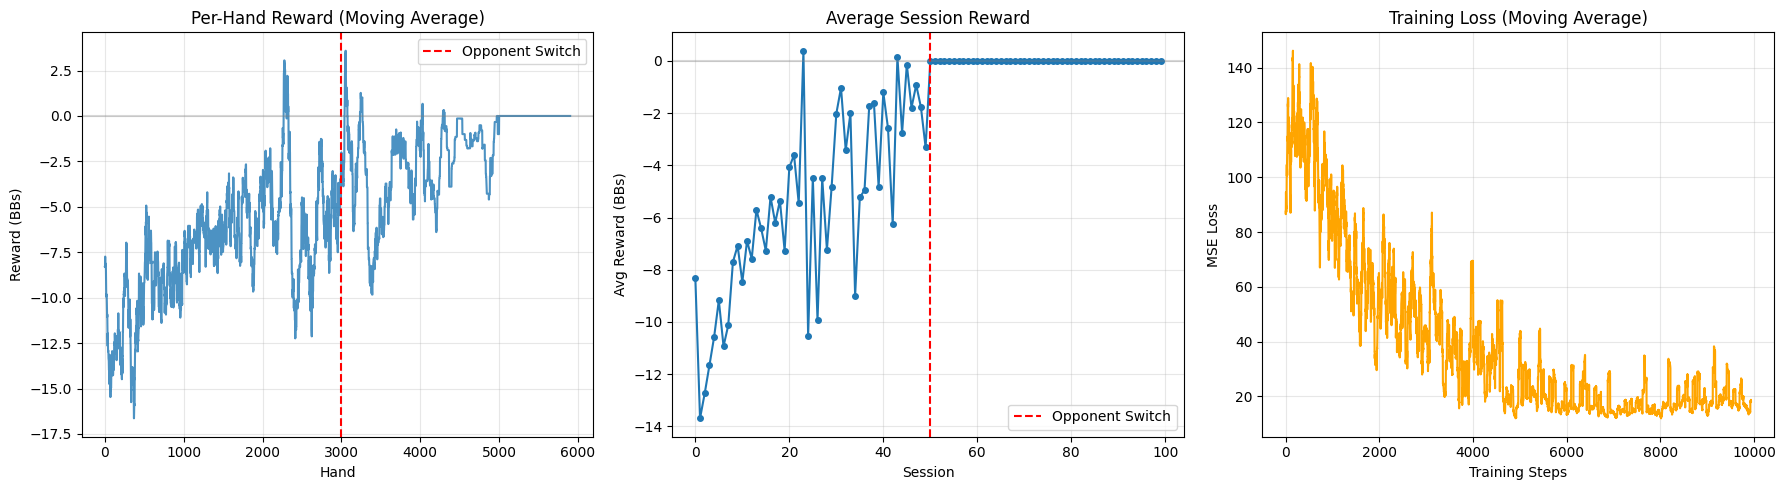

In [11]:
# Cell 11: Visualization

def moving_average(data, window=50):
    if len(data) < window:
        return data
    ret = np.cumsum(data, dtype=float)
    ret[window:] = ret[window:] - ret[:-window]
    return ret[window - 1:] / window

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Per-hand rewards
if len(rewards_history) > 100:
    ma_rewards = moving_average(rewards_history, window=100)
    axes[0].plot(ma_rewards, alpha=0.8)
else:
    axes[0].plot(rewards_history)
axes[0].axvline(x=len(rewards_history)//2, color='r', linestyle='--', label='Opponent Switch')
axes[0].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
axes[0].set_title('Per-Hand Reward (Moving Average)')
axes[0].set_xlabel('Hand')
axes[0].set_ylabel('Reward (BBs)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Per-session rewards
axes[1].plot(session_rewards, 'o-', markersize=4)
axes[1].axvline(x=len(session_rewards)//2, color='r', linestyle='--', label='Opponent Switch')
axes[1].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
axes[1].set_title('Average Session Reward')
axes[1].set_xlabel('Session')
axes[1].set_ylabel('Avg Reward (BBs)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Training loss
if loss_history:
    ma_loss = moving_average(loss_history, window=50)
    axes[2].plot(ma_loss, color='orange')
    axes[2].set_title('Training Loss (Moving Average)')
    axes[2].set_xlabel('Training Steps')
    axes[2].set_ylabel('MSE Loss')
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/tristanpank/repos/poker-bot-test/training_results_v3.png')
print("\nTraining plot saved to training_results_v3.png")
plt.show()

In [12]:
# Cell 12: Final Evaluation

print("\n" + "=" * 60)
print("FINAL EVALUATION")
print("=" * 60)

results = {}
for opp in ['random', 'maniac', 'nit']:
    results[opp] = evaluate_agent(agent, num_hands=100, opponent_type=opp)

print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
for opp, r in results.items():
    status = "✓ PASS" if r['avg_reward'] > 0 else "✗ FAIL"
    print(f"{opp.capitalize():10} | Avg: {r['avg_reward']:+.2f} BB/hand | {status}")


FINAL EVALUATION
[Session Reset] LSTM hidden state cleared.

=== Evaluation vs RANDOM ===
Hands: 100
W/L/T: 0/4/96
Win Rate: 0.0%
Total Profit: -250.0 BBs
Avg Profit/Hand: -2.50 BBs
[Session Reset] LSTM hidden state cleared.

=== Evaluation vs MANIAC ===
Hands: 100
W/L/T: 0/0/100
Win Rate: 0.0%
Total Profit: 0.0 BBs
Avg Profit/Hand: 0.00 BBs
[Session Reset] LSTM hidden state cleared.

=== Evaluation vs NIT ===
Hands: 100
W/L/T: 0/0/100
Win Rate: 0.0%
Total Profit: 0.0 BBs
Avg Profit/Hand: 0.00 BBs

SUMMARY
Random     | Avg: -2.50 BB/hand | ✗ FAIL
Maniac     | Avg: +0.00 BB/hand | ✗ FAIL
Nit        | Avg: +0.00 BB/hand | ✗ FAIL
